In [1]:
using ForwardDiff, Plots, NLsolve, LsqFit, Optim, Printf

In [2]:
k_B = 1.38e-23  # Boltzmann constant in J/K
T = 298  # Temperature in Kelvin
sigma = 0.0098  # Surface tension in J/m² (dyne/cm converted to J/m²)
a = 270e-9  # Droplet radius in meters
xi = 0.15  # Dimensionless parameter
epsilon_r = 78.5  # Relative permittivity of water
epsilon_0 = 8.85e-12  # Permittivity of vacuum in F/m
psi_0 = 270e-3  # Surface potential in volts
lambda_D = 3.4e-9  # Debye length in meters
phi_c = 0.646  # Critical volume fraction
alpha = 0.85  # Shear effect parameter
V_drop = (4/3) * π * a^3  # Droplet volume in cubic meters

8.244795760081054e-20

In [3]:
function F_int(phi_d)
    return 4 * π * xi * sigma * (a^2) * (phi_d^2) 
end

function F_ent(phi, phi_d, gamma)
    return -3 * k_B * T * log(phi_c + phi_d - phi - alpha * gamma^2)
end

function F_elec(phi_d, phi, gamma)
    h = 2 * phi_c^(1/3) * a * ((phi).^(-1/3) - (phi_c + phi_d - alpha * gamma^2).^(-1/3))
    return 2 * π * a^2 * epsilon_r * epsilon_0 * psi_0^2 * exp(-h / lambda_D) / h
end


function F_tot(phi_d, phi, gamma)
    term = phi_c + phi_d - phi - alpha * gamma^2
    if term <= 0
        return Inf  # Return a large value to avoid invalid log
    end
    return F_int(phi_d) + F_ent(phi, phi_d, gamma) + F_elec(phi_d, phi, gamma)
end


F_tot (generic function with 1 method)

In [4]:
function find_min_phi_d(phi, gamma)
    boundary_condition = phi_c - phi - alpha * gamma^2

    if boundary_condition > 0
        lower_bound = 0.0
    else
        lower_bound = phi + alpha * gamma^2 - phi_c
    end

    result = optimize(phi_d -> F_tot(phi_d, phi, gamma), lower_bound, 0.35, Brent())

    return Optim.minimizer(result), Optim.minimum(result)
end

find_min_phi_d (generic function with 1 method)

# G'p

In [5]:
@inline function parabolic_model(params, γ)
    # params[1] represents 'a', params[2] represents 'b', and params[3] represents 'c'
    return params[1] * γ^2 + params[2] * γ + params[3]
end

parabolic_model (generic function with 1 method)

The @inline keyword in Julia suggests that the function definition is marked for inlining, meaning the Julia compiler might replace the function call with the function body itself to improve performance, especially in performance-critical code or when the function is simple. It can sometimes make the code run faster by avoiding the overhead of a function call.

In [6]:
function fit_parabolic(phi, gamma_values)
    # Find the value of phi_d* that minimizes the free energy
    phi_d_star, _ = find_min_phi_d(phi, gamma_values[1])
    
    # Compute F_tot for a range of small gamma values
    F_tot_values = [F_tot(phi_d_star, phi, γ) for γ in gamma_values]
    
    # Perform least squares fitting to the parabolic model
    fit_params = LsqFit.curve_fit(parabolic_model, gamma_values, F_tot_values, [1.0, 1.0, 0.0])

    a = fit_params.param[1]
    curvature = 2 * a
    
    return curvature
end

function G_p(phi, gamma_values)
    # Calculate curvature using the parabolic fitting
    curvature = fit_parabolic(phi, gamma_values)
    
    # Calculate G_p' using the formula from the paper
    return (phi / V_drop) * curvature
end

# Example usage: calculate G_p' for a given phi and range of gamma values
phi = 0.5  # Example value for phi
gamma_values = range(0.0, 0.01, length=100)  # Small range of gamma values
G_p_prime = G_p(phi, gamma_values)

println("G_p' = $G_p_prime")

MethodError: MethodError: no method matching ^(::Vector{Float64}, ::Int64)
The function `^` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  ^(!Matched::BigInt, ::Integer)
   @ Base gmp.jl:649
  ^(!Matched::Irrational{:ℯ}, ::Integer)
   @ Base mathconstants.jl:119
  ^(!Matched::BigFloat, ::Union{Int16, Int32, Int64, Int8})
   @ Base mpfr.jl:717
  ...


# Checking the property of Phi_d

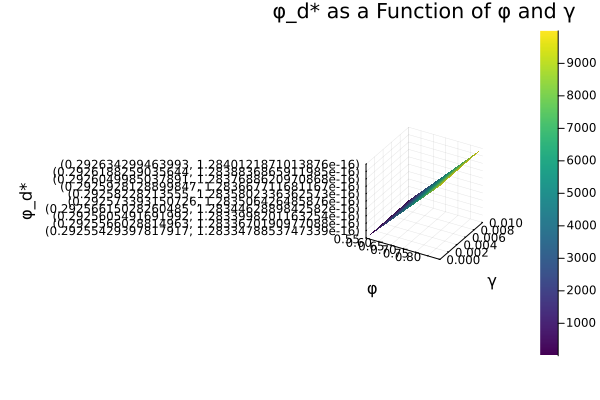

In [7]:
phi_values = range(0.55, 0.85, length=100)
gamma_values = range(0.0, 0.01, length=100)

phid_star_matrix = [find_min_phi_d(phi, gamma) for phi in phi_values, gamma in gamma_values]

surface(phi_values, gamma_values, phid_star_matrix, xlabel="φ", ylabel="γ", zlabel="φ_d*", title="φ_d* as a Function of φ and γ", c=:viridis)

plot!()

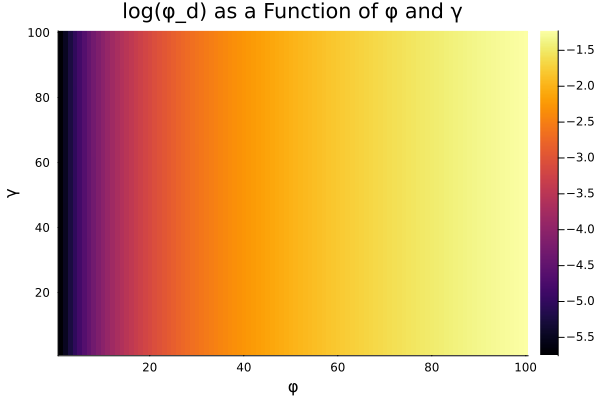

In [8]:
phi_d_values = zeros(length(phi_values), length(gamma_values))
for i in 1:length(phi_values)
    for j in 1:length(gamma_values)
        phi = phi_values[i]
        gamma = gamma_values[j]
        phi_d, _ = find_min_phi_d(phi, gamma)
        phi_d_values[i, j] = phi_d
    end
end

heatmap(log.(phi_d_values)', xlabel="φ", ylabel="γ", zlabel="log(φ_d)", title="log(φ_d) as a Function of φ and γ")


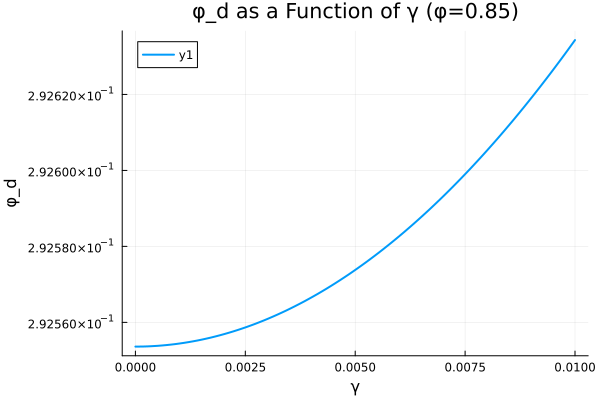

In [9]:
phi_fixed = 0.85

gamma_values = range(0, 0.01, length=100)

phi_d_values = zeros(length(gamma_values))

for i in 1:length(gamma_values)
    gamma = gamma_values[i]
    phi_d, _ = find_min_phi_d(phi_fixed, gamma)
    phi_d_values[i] = phi_d
end

plot(gamma_values, phi_d_values, xlabel="γ", ylabel="φ_d", title="φ_d as a Function of γ (φ=$phi_fixed)", lw=2)

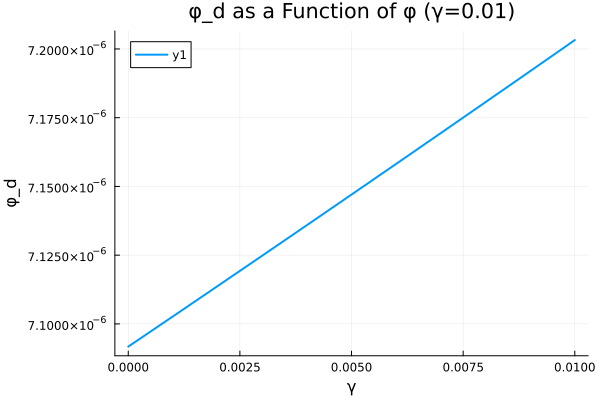

In [10]:
gamma_fixed = 0.01

phi_values = range(0, 0.01, length=100)

phi_d_values = zeros(length(phi_values))

for i in 1:length(phi_values)
    phi = phi_values[i]
    phi_d, _ = find_min_phi_d(phi, gamma_fixed)
    phi_d_values[i] = phi_d
end

plot(phi_values, phi_d_values, xlabel="γ", ylabel="φ_d", title="φ_d as a Function of φ (γ=$gamma_fixed)", lw=2)

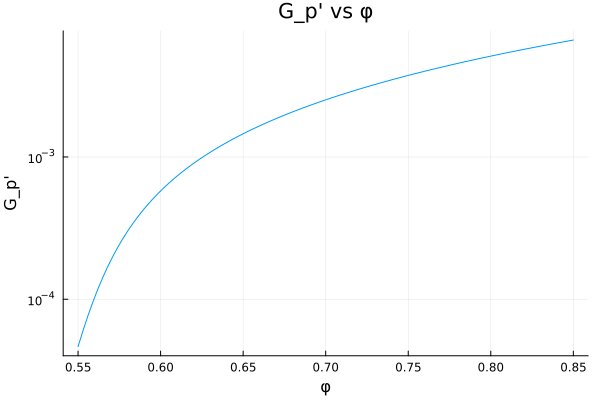

In [11]:


k_B = 1.38e-23  # Boltzmann constant in J/K
T = 298  # Temperature in Kelvin
sigma = 0.0098  # Surface tension in J/m²
a = 270e-9  # Droplet radius in meters
xi = 0.15  # Dimensionless parameter
epsilon_r = 78.5  # Relative permittivity of water
epsilon_0 = 8.85e-12  # Permittivity of vacuum in F/m
psi_0 = 270e-3  # Surface potential in volts
lambda_D = 3.4e-9  # Debye length in meters
phi_c = 0.646  # Critical volume fraction
alpha = 0.85  # Shear effect parameter
V_drop = (4/3) * π * a^3  # Droplet volume in cubic meters

function F_int(phi_d)
    return 4 * π * xi * sigma * (a^2) * (phi_d^2)
end


function F_ent(phi, phi_d, gamma)
    term = phi_c + phi_d - phi - alpha * gamma^2
    return -3 * k_B * T * log(term)
end

function F_elec(phi_d, phi, gamma)
    h = 2 * phi_c^(1/3) * a * (phi^(-1/3) - (phi_c + phi_d - alpha * gamma^2)^(-1/3))  
    return 2 * π * a^2 * epsilon_r * epsilon_0 * psi_0^2 * exp(-h / lambda_D) / h
end

function F_tot(phi_d, phi, gamma)
    return F_int(phi_d) + F_ent(phi, phi_d, gamma) + F_elec(phi_d, phi, gamma)
end

function find_min_phi_d(phi, gamma)
    boundary_condition = phi_c - phi - alpha * gamma^2

    if boundary_condition > 0
        lower_bound = 0.0
    else
        lower_bound = phi + alpha * gamma^2 - phi_c
    end

    result = optimize(phi_d -> F_tot(phi_d, phi, gamma), lower_bound, 0.35, Brent())

    return Optim.minimizer(result), Optim.minimum(result)
end


phi_vals = range(0.55, 0.85, length=100)
gamma_vals = range(0, 0.01, length=100)

G_p_values = Float64[]  # To store G_p' for each phi
G_p_int_values = Float64[]
G_p_ent_values = Float64[]
G_p_elec_values = Float64[]

for phi in phi_vals
    gamma_list = Float64[]
    F_tot_star_list = Float64[]
    F_int_star_list = Float64[]
    F_ent_star_list = Float64[]
    F_elec_star_list = Float64[]
    
    for gamma in gamma_vals
        phi_d_star, _ = find_min_phi_d(phi, gamma)
        F_tot_star = F_tot(phi_d_star, phi, gamma)
        F_int_star = F_int(phi_d_star)
        F_ent_star = F_ent(phi, phi_d_star, gamma)
        F_elec_star = F_elec(phi_d_star, phi, gamma)
        push!(gamma_list, gamma)
        push!(F_tot_star_list, F_tot_star)
        push!(F_int_star_list, F_int_star)
        push!(F_ent_star_list, F_ent_star)
        push!(F_elec_star_list, F_elec_star)
    end

    
    model(gamma, p) = p[1] .+ p[2] .* gamma .+ p[3] .* gamma.^2
    p0 = [minimum(F_tot_star_list), 0.0, 0.0]  #initial guess
    fit = curve_fit(model, gamma_list, F_tot_star_list, p0)
    fit_int = curve_fit(model, gamma_list, F_int_star_list, p0)
    fit_ent = curve_fit(model, gamma_list, F_ent_star_list, p0)
    fit_elec = curve_fit(model, gamma_list, F_elec_star_list, p0)
    a0, a1, a2 = coef(fit)
    int_a0, int_a1, int_a2 = coef(fit_int)
    ent_a0, ent_a1, ent_a2 = coef(fit_ent)
    elec_a0, elec_a1, elec_a2 = coef(fit_elec)
    second_derivative = 2 * a2
    second_derivative_int = 2 * int_a2
    second_derivative_ent = 2 * ent_a2
    second_derivative_elec = 2 * elec_a2

    G_p_prime = (phi / V_drop) * second_derivative
    G_p_prime_int = (phi / V_drop) * second_derivative_int
    G_p_prime_ent = (phi / V_drop) * second_derivative_ent
    G_p_prime_elec = (phi / V_drop) * second_derivative_elec
    push!(G_p_values, G_p_prime)
    push!(G_p_int_values, G_p_prime_int)
    push!(G_p_ent_values, G_p_prime_ent)
    push!(G_p_elec_values, G_p_prime_elec)
end

# Convert G_p_values to an array
# G_p_values = collect(G_p_values)

# Handle NaN values in G_p_values
# valid_indices = findall(!isnan, G_p_values)
# phi_vals_valid = phi_vals[valid_indices]
# G_p_values_valid = G_p_values[valid_indices]

# Plot G_p' vs phi with log scale on y-axis
plot(phi_vals, (G_p_values * a / sigma), xlabel="φ", ylabel="G_p'", title="G_p' vs φ", legend=false, yscale=:log10)


The core principle of `curve_fit` is **least squares fitting**. Its goal is to find a set of parameters \( p \) such that the predicted values from the model `model(gamma_list, p)` best fit the observed data `F_tot_star_list`. The optimization target function is:

$$
\text{Minimize} \sum_{i} \left( F_{\text{tot},i} - f(\gamma_i, p) \right)^2
$$

Where $ F_{\text{tot},i} $ are the observed data points and $ f(\gamma_i, p) $ are the values calculated from the model. The goal is to minimize the sum of squared differences between them by adjusting $ p $.
